# Explore Exercises

In [1]:
#spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F  

#numeric imports
import numpy as np
import pandas as pd

#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#remove warnings
import warnings
warnings.filterwarnings("ignore")

#custom functions
import wrangle

In [2]:
#create spark object
spark = SparkSession.builder.getOrCreate()

<hr style="border:2px solid black"> </hr>

## Wrangle the data first

In [3]:
# Read in case CSV file 
case = (spark.read.csv("case.csv",
                     sep=",",
                     header=True,
                     inferSchema=True)
     )

In [4]:
# Read in department CSV file 
dept = (spark.read.csv("dept.csv",
                     sep=",",
                     header=True,
                     inferSchema=True)
     )

In [5]:
# Read in source CSV file 
source = (spark.read.csv("source.csv",
                     sep=",",
                     header=True,
                     inferSchema=True)
     )

In [6]:
#no foreign keys in common between source and dept
#join case and dept first
join_df = (
    case
    # left join on dept_division
    .join(dept, "dept_division", "left")
     # drop all the columns except for standardized name, as it has much fewer unique values
    .drop(dept.dept_division)
    .drop(dept.dept_name)
    .drop(case.dept_division)
    .withColumnRenamed("standardized_dept_name", "department")
    # convert to a boolean
    .withColumn("dept_subject_to_SLA", col("dept_subject_to_SLA") == "YES")
)

In [7]:
#used join_df to join with source now
#this is all three dataframes together
df = (
    case
    # left join on dept_division
    .join(source, "source_id", "left")
     # drop all the columns except for standardized name, as it has much fewer unique values
    # convert to a boolean
)

In [8]:
#create another df using wrangle function from wrangle.py
df2 = wrangle.wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


<hr style="border:2px solid black"> </hr>

## Take a look at our data

In [9]:
#show first 2 sets of data, truncated-false, vertical- true
df.show(2, False, True)

-RECORD 0----------------------------------------------------
 source_id            | svcCRMLS                             
 case_id              | 1014127332                           
 case_opened_date     | 1/1/18 0:42                          
 case_closed_date     | 1/1/18 12:29                         
 SLA_due_date         | 9/26/20 0:42                         
 case_late            | NO                                   
 num_days_late        | -998.5087616000001                   
 case_closed          | YES                                  
 dept_division        | Field Operations                     
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 5                                    
 source_username      | svcCRMLS                             
-RECORD 

In [10]:
df.dtypes

[('source_id', 'string'),
 ('case_id', 'int'),
 ('case_opened_date', 'string'),
 ('case_closed_date', 'string'),
 ('SLA_due_date', 'string'),
 ('case_late', 'string'),
 ('num_days_late', 'double'),
 ('case_closed', 'string'),
 ('dept_division', 'string'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('request_address', 'string'),
 ('council_district', 'int'),
 ('source_username', 'string')]

In [11]:
df2.show(2, False, True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

In [12]:
df2.dtypes

[('case_id', 'int'),
 ('case_opened_date', 'timestamp'),
 ('case_closed_date', 'timestamp'),
 ('case_due_date', 'timestamp'),
 ('case_late', 'boolean'),
 ('num_days_late', 'double'),
 ('case_closed', 'boolean'),
 ('service_request_type', 'string'),
 ('SLA_days', 'double'),
 ('case_status', 'string'),
 ('source_id', 'string'),
 ('request_address', 'string'),
 ('council_district', 'string'),
 ('num_weeks_late', 'double'),
 ('zipcode', 'string'),
 ('case_age', 'int'),
 ('days_to_closed', 'int'),
 ('case_lifetime', 'int'),
 ('department', 'string'),
 ('dept_subject_to_SLA', 'boolean')]

**will use df2- has more clean data**

<hr style="border:2px solid black"> </hr>

# Exercises

### #1. How many different cases are there, by department?

In [13]:
#group by departments
df2.groupBy('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



Text(0.5, 0, 'Number of Cases')

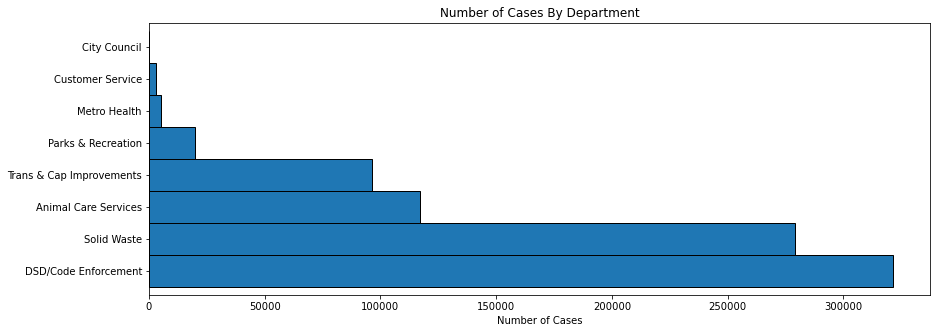

In [14]:
# First aggregate with spark
(
    df2.groupBy("department")
    #aggregate by count
    .count()
    # then pass to pandas
    .toPandas()
    #place department as index
    .set_index("department")["count"]
    #sort values
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

<hr style="border:1px solid black"> </hr>

### #2. Does the percentage of cases that are late vary by department?

In [15]:
#shows if case was late or not
df2.groupBy('case_late').count().show()

+---------+------+
|case_late| count|
+---------+------+
|     true| 94503|
|    false|747201|
+---------+------+



In [16]:
#shows how many cases late by deparment
df2.groupby("Department").agg(F.count("case_late")).show() 

+--------------------+----------------+
|          Department|count(case_late)|
+--------------------+----------------+
|         Solid Waste|          279270|
|Animal Care Services|          116915|
|Trans & Cap Impro...|           96193|
|  Parks & Recreation|           19907|
|    Customer Service|            2849|
|        Metro Health|            5163|
|        City Council|              33|
|DSD/Code Enforcement|          321374|
+--------------------+----------------+



Text(0.5, 1.0, '% of Late Cases By Department')

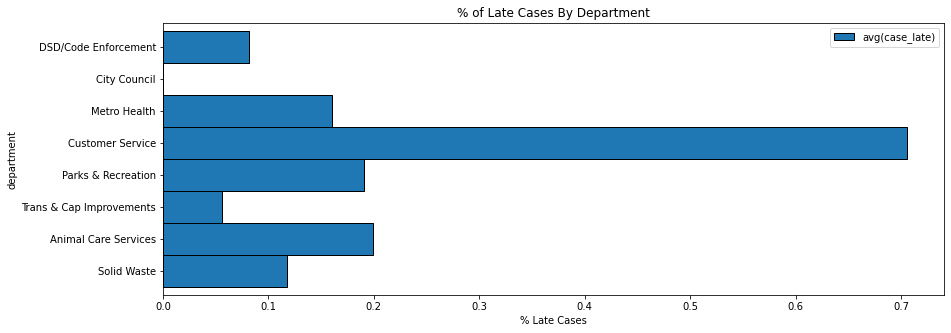

In [18]:
(#turn case_late into an int
    df2.withColumn("case_late", col("case_late").cast("int"))
    #group by departments
    .groupby("department")
    #get average of case lates
    .agg(avg("case_late"))
    #turn into pandas df
    .toPandas()
    #set the index to deparments
    .set_index("department")
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)
plt.xlabel("% Late Cases")
plt.title("% of Late Cases By Department")

<hr style="border:1px solid black"> </hr>

### #3. On average, how late are the late cases by department?

In [29]:
(
df2.case.where(case.case_late =='true')
.groupBy('department')
.agg(mean("num_days_late"))
.toPandas()
.set_index('department')
.plt.barh(width=1, figuresize=(14,5))
)

AttributeError: 'DataFrame' object has no attribute 'case'

<hr style="border:1px solid black"> </hr>

### #4. What is the service type that is the most late? Just for Parks & Rec?

<hr style="border:1px solid black"> </hr>

### #5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

<hr style="border:1px solid black"> </hr>

### #6. Does whether or not its a weekend matter for when a case is opened/closed?

In [23]:
cases = (
    df2
    .groupBy('case_closed_date')
    .count()
    .na.drop()
    .sort('case_closed_date')
    .toPandas()
    .assign(case_closed_date = lambda df: pd.to_datetime(df.case_closed_date))
    .set_index('case_closed_date')
    ['count']
)

In [26]:
cases = cases.reset_index()

In [27]:
cases['dow'] = cases.case_closed_date.dt.day_name()

<hr style="border:1px solid black"> </hr>

### #7. On average, how many cases are opened a day for the Customer Service department?

<hr style="border:1px solid black"> </hr>

### #8. Does the number of service requests for the solid waste department vary by day of the week?